# Applying OT-intNMF to PBMC

## Imports

In [1]:
# Biology
import scanpy as sc
import muon as mu

In [2]:
# Plotting
import matplotlib.pyplot as plt

In [3]:
# Our packages
from mowgli import models, pl, tl, utils

In [4]:
import numpy as np

## Load data

Load the preprocessed PBMC dataset from 10X Genomics (scRNA-seq + scATAC-seq).

In [5]:
mdata = mu.read_h5mu('../datasets/pbmc_preprocessed.h5mu.gz')

For computational reasons, in this demonstration we reduce the number of features and subsample the cells.

In [6]:
sc.pp.highly_variable_genes(mdata['rna'], n_top_genes=800)
sc.pp.highly_variable_genes(mdata['atac'], n_top_genes=800)

In [7]:
# Perform the subsampling.
sc.pp.subsample(mdata['rna'], n_obs=500, random_state=0)
sc.pp.subsample(mdata['atac'], n_obs=500, random_state=0)

# Create a MuData object with rna and atac.
mdata = mu.MuData({'rna': mdata['rna'], 'atac': mdata['atac']})

## Visualize independant modalities

Let us visualize the cell lines independantly using UMAP projections.

In [8]:
# Reorder categories.
ordered_cat = ['CD56 (bright) NK cells', 'CD56 (dim) NK cells', 'MAIT T cells', 'effector CD8 T cells', 'naive CD8 T cells', 'naive CD4 T cells', 'memory CD4 T cells', 'naive B cells', 'memory B cells', 'classical monocytes', 'intermediate monocytes', 'non-classical monocytes', 'myeloid DC', 'plasmacytoid DC']
mdata['rna'].obs['celltype'] = mdata['rna'].obs['celltype'].cat.reorder_categories(ordered_cat)
mdata['atac'].obs['celltype'] = mdata['atac'].obs['celltype'].cat.reorder_categories(ordered_cat)
mdata.obs['rna:celltype'] = mdata.obs['rna:celltype'].cat.reorder_categories(ordered_cat)
mdata.obs['atac:celltype'] = mdata.obs['atac:celltype'].cat.reorder_categories(ordered_cat)

In [9]:
# Umap RNA
sc.pp.scale(mdata['rna'], zero_center=False)
sc.tl.pca(mdata['rna'], svd_solver='arpack')
sc.pp.neighbors(mdata['rna'], n_neighbors=10, n_pcs=10)
sc.tl.umap(mdata['rna'], spread=1.5, min_dist=.5)

In [10]:
# Umap ATAC
sc.pp.scale(mdata['atac'], zero_center=False)
sc.tl.pca(mdata['atac'], svd_solver='arpack')
sc.pp.neighbors(mdata['atac'], n_neighbors=10, n_pcs=10)
sc.tl.umap(mdata['atac'], spread=1.5, min_dist=.5)

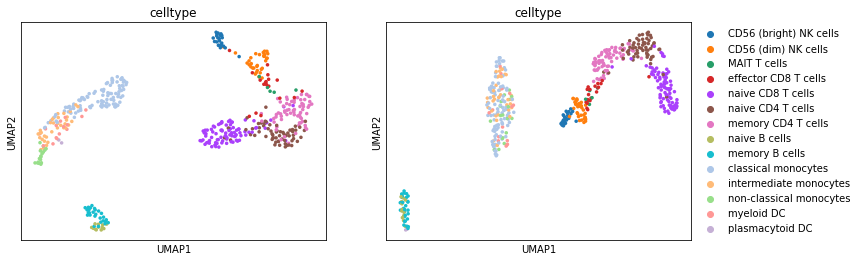

In [11]:
# Display UMAP
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sc.pl.umap(mdata['rna'], color="celltype", legend_loc="none", size=50, show=False, ax=axes[0])
sc.pl.umap(mdata['atac'], color="celltype", size=50, show=False, ax=axes[1])
plt.show()

## Train model

Let us define the model and perform the dimensionaly reduction.

In [15]:
# Define the model.
nmf = models.MowgliModel(
    latent_dim=18,
    rho_h=1e-2,
    rho_w=1e-3,
    eps=.1,
    cost='cosine')

In [16]:
# Perform the training.
nmf.train(mdata)

  4%|▍         | 8/200 [02:32<1:00:53, 19.03s/it, loss=0.04542893, mass_transported=0.806, loss_inner=-0.049918152, inner_steps=170, gpu_memory_allocated=0]


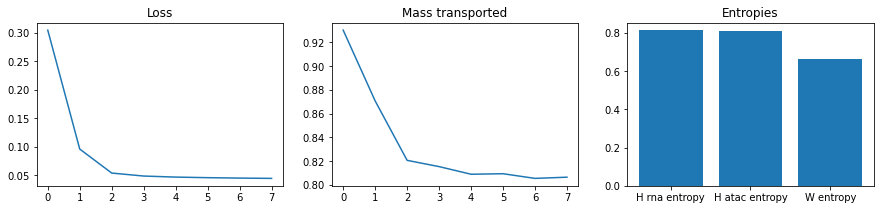

In [17]:
# Display the training statistics.
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
axes[0].set_title('Loss')
axes[0].plot(nmf.losses)

axes[1].set_title('Mass transported')
axes[1].plot(nmf.scores_history[1:])

entropies, labels = [], []
for mod in nmf.mod:
    entropies.append(utils.entropy(nmf.H[mod], rescale=True))
    labels.append(' '.join(['H', mod, 'entropy']))
entropies.append(utils.entropy(nmf.W, rescale=True))
labels.append('W entropy')
axes[2].set_title('Entropies')
axes[2].bar(labels, entropies)

plt.show()

## Visualize the embedding

Now, let us display the obtained embedding.

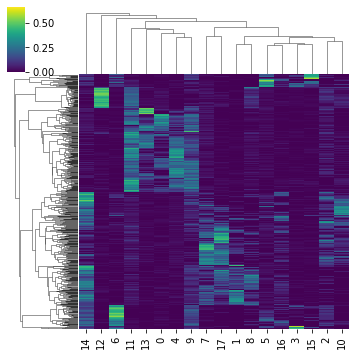

In [18]:
# First, using a dendogram.
pl.clustermap(mdata, 'W_OT', yticklabels=False, figsize=(5, 5))

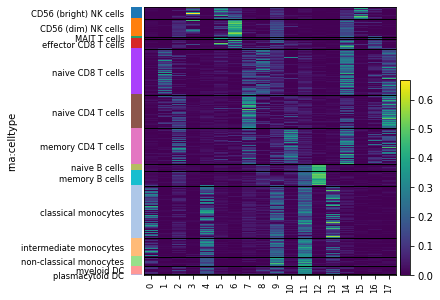

In [19]:
# Then, using the ground truth clusters.
pl.heatmap(mdata, 'W_OT', 'rna:celltype', figsize=(5, 5))

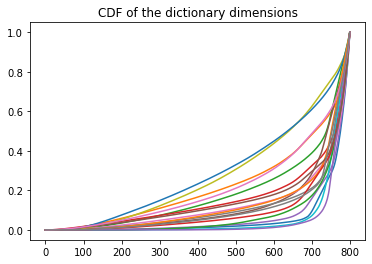

In [20]:
plt.title('CDF of the dictionary dimensions')
for i in range(nmf.H['rna'].shape[1]):
    plt.plot(np.cumsum(np.sort(nmf.H['rna'].numpy()[:,i])))
plt.show()

In [21]:
# Finally, we can compute an UMAP embedding
tl.umap(mdata, 'W_OT')

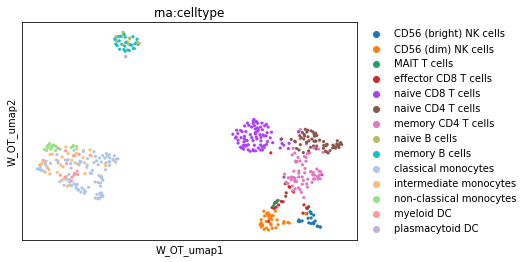

In [22]:
# And display it.
mu.pl.embedding(mdata, 'W_OT_umap', 'rna:celltype', size=40)

## Analyse a given factor

We can zoom in on a particular factor to interpret it biologically.

In [23]:
# Display the 3 highest contributors to a given dimension, for RNA-seq.
tl.top_features(mdata, 'rna', 'H_OT', dim=3, n_features=5)

['NCR1', 'SH2D1B', 'CLIC3', 'XCL2', 'BNC2']

In [24]:
# Query g:profiler for Gene Set Enrichment Analysis, and display the results for a certain dimension.
enr, _ = tl.enrich(mdata, 'rna', n_genes=100, ordered=True, domain_scope='annotated')
enr[enr['query'] == 'dimension 3'].head()[['source', 'name', 'p_value']]

,source,name,p_value
7,GO:BP,immune response,8.086309e-10
24,GO:BP,immune system process,1.569105e-07
28,GO:CC,cytolytic granule,3.587657e-07
40,GO:BP,cell killing,8.866307e-07
44,GO:BP,defense response to other organism,1.204744e-06


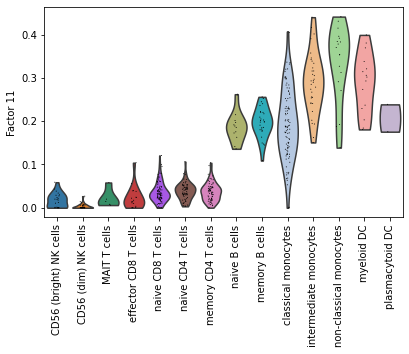

In [25]:
# Display a violin plot of the value at a certain dimension of the cells.
pl.factor_violin(mdata, groupby='rna:celltype', dim=11, rotation=90)

## Clustering

We can perform clustering on the lower-dimensional space.

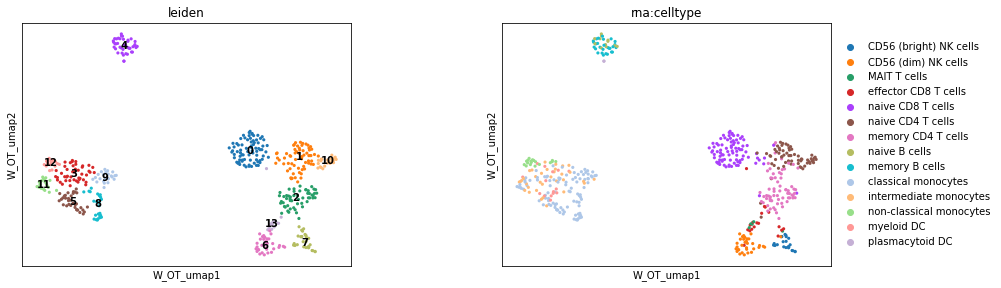

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.tight_layout(pad=12.0)
tl.leiden(mdata, resolution=1.5)
mu.pl.embedding(mdata, 'W_OT_umap', 'leiden', legend_loc='on data', size=40, ax=axes[0], show=False)
mu.pl.embedding(mdata, 'W_OT_umap', 'rna:celltype', size=40, ax=axes[1])